## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data**
- **[Part 3](#part3) -  Linear Regression**
- **[Part 4](#part4) -  Lasso Regression**
- **[Part 5](#part5) -  Naive Bayes**
- **[Part 6](#part6) - Gradient Boost Classifier**
- **[Part 7](#part6) - Cat Boost Classifier**
- **[Part 8](#part6) - XGB Boost Classifier**


The problem can also be viewed as a regression problem, since categories can be ranked we can use regression and then map the prediction result to a category. Our intuition is that by making the model learn classification of the categories using regression might improve our results.

[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [2]:
random.seed(0)

In [3]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [4]:
# Dropping na values for 
df = df.dropna()

In [5]:
# Dropping case_id
df.drop(['case_id'], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data

### Hot Encoded Data

In [6]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [52]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay', 'patientid'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and splitting Data

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

### Scoring

In [9]:
K = 10 # Num of Classes 
# Classes can be ranked here from 0-10
def score(pred, target):
    error = (np.mean(np.abs(pred-target)))/K
    score = 1 - error
    return score

# Models

We start by a base model, models used here are that are most adapted to the nature of the problem :
- Linear Regression
- Lasso Regression
- One Hidden Layer ANN
- Two Hidden Layer ANN


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

### Fitting Linear Regression on the whole dataset

In [54]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [55]:
y_pred = model.predict(X)


In [56]:
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 23.563992639767644
y_pred.min() -1.3908390607728123


The range of y is from 0 to 10, we can see that the regression have values that are out of bound. We write a function to map the prediction to categories.

In [33]:
def cat(x):
    cat_x = np.maximum(x, 0)
    cat_x = np.minimum(cat_x, 10)
    cat_x = np.floor(cat_x)
    cat_x = cat_x.astype(int)
    return cat_x

In [57]:
from sklearn.metrics import accuracy_score
K = 10
y_pred = cat(y_pred)
accuracy = accuracy_score(y_pred, y)
score = 1 - (np.mean(np.abs(y_pred-y)))/K
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

Accuracy : 0.305
Score : 0.8784


We can see that the score is high compared to accuracy if we take into account the previous results we got, this is makes sense since regression optimise for the distance between categories here which is equivalent to optimising for the score.

### Confusion matrix

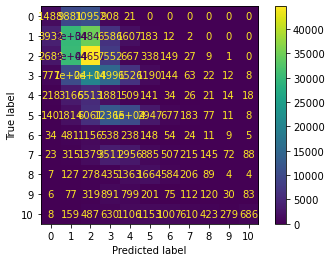

In [58]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

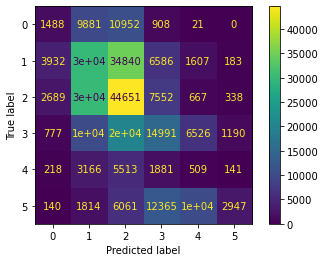

In [59]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

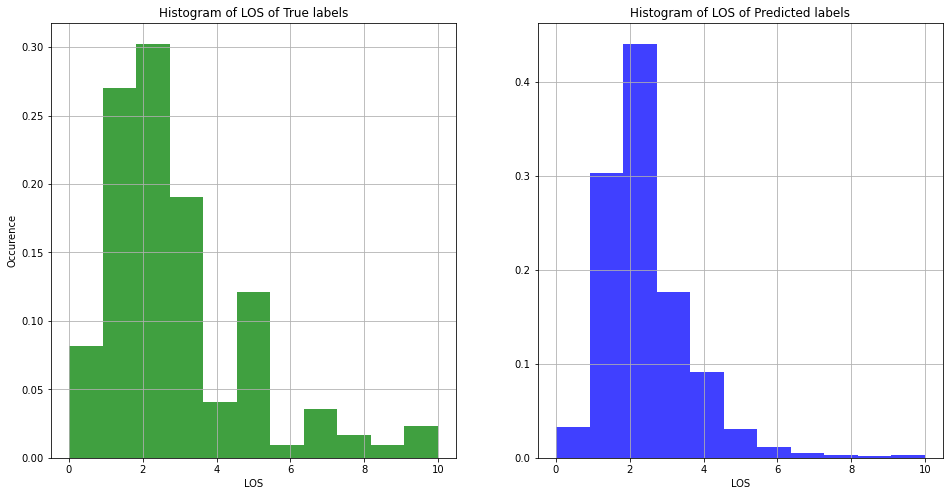

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y, bins=11, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11,  density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Linear regression suffer from different problems, it also over predicts cat 1 and 2 but it neglects cat 5 

### Fitting Linear Regression on the training dataset

In [41]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 23.23759422665279
y_pred.min() -1.1959995233472132


In [43]:
from sklearn.metrics import mean_squared_error

y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.76
Accuracy : 0.305
Score : 0.8789


We have similar results to those we get when we fit on the whole dataset. A question we might ask is if there are any features that prevents us from getting better results. We will explore that using Lasso regression.

[Back to top](#Content:)


<a id='part4'></a>

# Part 4 -  Lasso Regression

It doesnt make much different weather we fit the regression on the whole dataset or only training set, we will try with training dataset

In [61]:
from sklearn.linear_model import Lasso
# Create linear regression
regressor = Lasso(alpha=0.1)

# Fit/train LASSO
regressor.fit(X_train,y_train)
# Predict
y_pred = regressor.predict(X_test)
print('y_pred.max()',y_pred.max() )
print('y_pred.min()',y_pred.min() )

y_pred.max() 20.7674567645083
y_pred.min() 0.40156519599156404


In [62]:
y_pred = cat(y_pred)

accuracy = accuracy_score(y_pred, y_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
error = np.sqrt(mean_squared_error(y_pred,y_test))
mean = np.mean(y_test)

print('mean y_test: %.2f' % mean)
print('RMSE : %.2f' % error)
print(f'Accuracy : %.3f' % accuracy)
print(f'Score : %.4f' % score)

mean y_test: 2.69
RMSE : 1.80
Accuracy : 0.314
Score : 0.8776


Results are slightly better than regression, but here we are looking for features to keep/drop

In [63]:
# Function to plot Lasso coef
def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': np.abs(coef)  }, index = names )
    r = r.sort_values(by=['positive'], ascending=False)
    display(r)
    print("Intercept: {}".format(intercept))
    #plt.xlabel('covariate coefficient')
    #r['coef'].plot(kind='barh')

In [64]:
names = list(Xe.columns.values)
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

,coef,positive
Visitors with Patient,1.094805,1.094805
Ward_Type-S,0.210604,0.210604
Ward_Type-Q,-0.155312,0.155312
Available Extra Rooms in Hospital,-0.133706,0.133706
Severity of Illness,0.116297,0.116297
Type of Admission-Emergency,-0.062019,0.062019
Type of Admission-Trauma,0.060036,0.060036
Ward_Facility_Code-C,-0.052824,0.052824
Ward_Type-P,-0.042891,0.042891
Hospital_type_code-a,-0.008528,0.008528


Intercept: 2.698585899789245


It seems many of the feature are eliminated by Lasso, following the results we will keep only thease feature for our next LinearRegression model :
- Visitors
- Ward Type 
- Available extra rooms
- Severity of Illness
- Type of Admission


[Back to top](#Content:)


<a id='part5'></a>

# Part 5 -  Linear Regression with reduced features

In [ ]:
features = ['Visitors with Patient', 'Ward_Type', 'Available Extra Rooms in Hospital', 'Severity of Illness', 'Type of Admission']
